# Adding GradCAM to Retinanet
## SUMMARY:
### GOAL:
- The goal of this notebook is to add GradCAM visualization on Retinanet to understand what part of images contribute to the final predictions
### CHALLENGES:
- There are multiple challenges when I attempt to visualize the CAM for Retinanet:
1. CAMs for Object Detection Model (ODM): ODM often do a lot of processing on results (e.g do argmax on scores to find highest scoring category, create dictionaries for bounding boxes, etc.), which means the typical outputs are not **differentiable** by common GradCAM packages such as pytorch-grad-cam. That said, I have to switch to "gradient free" methods, namely: EignenCAM and AblationCAM

2. On top of that, the Pytorch implementation of Retinanet is quite different from standard ODM. For instances, the classifier layer (the one that contains the layer of interest for CAM) process **individual feature** of the FPN, which means I have to manually compute the activations in order to visualize CAM (using EigenCAM). 

3. Due to (2), I failed to use the AblationCAM for Retinanet

### Results:
- Successfully visualized CAM using EignenCAM

In [1]:
import torch
from retinanet import model

d:\SOFTWARE\Anaconda\envs\pytorch_1.13\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# # NOTE: THIS CELL IS ONLY FOR INITIALIZE MODEL, IN LATER STAGE, I WILL LOAD THE MODEL FROM CHECKPOINT SO THERE IS NO NEED TO RUN THIS CELL
# retinanet = model.resnet50(80)
# retinanet.load_state_dict(torch.load("./coco_resnet_50_map_0_335_state_dict.pt"))
# torch.save(retinanet, "retinanet_pretrained.pt")

<All keys matched successfully>

In [6]:
import pandas as pd
# Define classes of the COCO dataset
classes = """person
bicycle
car
motorcycle
airplane
bus
train
truck
boat
traffic light
fire hydrant
stop sign
parking meter
bench
bird
cat
dog
horse
sheep
cow
elephant
bear
zebra
giraffe
backpack
umbrella
handbag
tie
suitcase
frisbee
skis
snowboard
sports ball
kite
baseball bat
baseball glove
skateboard
surfboard
tennis racket
bottle
wine glass
cup
fork
knife
spoon
bowl
banana
apple
sandwich
orange
broccoli
carrot
hot dog
pizza
donut
cake
chair
couch
potted plant
bed
dining table
toilet
tv
laptop
mouse
remote
keyboard
cell phone
microwave
oven
toaster
sink
refrigerator
book
clock
vase
scissors
teddy bear
hair drier
toothbrush"""
class_lst = classes.split("\n")
cat_ids = list(range(len(class_lst)))
df = pd.DataFrame({"class": class_lst, "id": cat_ids})
df.to_csv("class_mapping.csv", header=False, index=False)

In [7]:
# NOTE: This cell is a modified version of visualize_single_image.py
# The goal is to visualize the image as well as inferences from Retinanet on the picture


import torch
import numpy as np
import time
import os
import csv
import cv2
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

def load_classes(csv_reader):
    result = {}

    for line, row in enumerate(csv_reader):
        line += 1

        try:
            class_name, class_id = row
        except ValueError:
            raise(ValueError('line {}: format should be \'class_name,class_id\''.format(line)))
        class_id = int(class_id)

        if class_name in result:
            raise ValueError('line {}: duplicate class name: \'{}\''.format(line, class_name))
        result[class_name] = class_id
    return result


# Draws a caption above the box in an image
def draw_caption(image, box, caption):
    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1)

def detect_image(image_path, model_path, class_list):

    with open(class_list, 'r') as f:
        classes = load_classes(csv.reader(f, delimiter=','))

    labels = {}
    for key, value in classes.items():
        labels[value] = key

    model = torch.load(model_path)

    if torch.cuda.is_available():
        model = model.cuda()

    model.training = False
    model.eval()

    for img_name in os.listdir(image_path):

        image = cv2.imread(os.path.join(image_path, img_name))
        if image is None:
            continue
        image_orig = cv2.resize(image.copy(), (640,640))

        rows, cols, cns = image.shape

        smallest_side = min(rows, cols)

        # rescale the image so the smallest side is min_side
        min_side = 608
        max_side = 1024
        scale = min_side / smallest_side

        # check if the largest side is now greater than max_side, which can happen
        # when images have a large aspect ratio
        largest_side = max(rows, cols)

        if largest_side * scale > max_side:
            scale = max_side / largest_side

        # resize the image with the computed scale
        # image = cv2.resize(image, (int(round(cols * scale)), int(round((rows * scale)))))
        image = cv2.resize(image, (640, 640))
        rows, cols, cns = image.shape

        new_image = np.zeros((rows, cols, cns)).astype(np.float32)
        # new_image = np.zeros((640, 640, 3)).astype(np.float32)
        new_image[:rows, :cols, :] = image.astype(np.float32)
        image = new_image.astype(np.float32)
        image /= 255
        image -= [0.485, 0.456, 0.406]
        image /= [0.229, 0.224, 0.225]
        image = np.expand_dims(image, 0)
        image = np.transpose(image, (0, 3, 1, 2))

        lbs, bboxes = [], []
        with torch.no_grad():

            image = torch.from_numpy(image)
            if torch.cuda.is_available():
                image = image.cuda()

            st = time.time()
            print(image.shape, image_orig.shape, scale)
            scores, classification, transformed_anchors = model(image.cuda().float())
            print('Elapsed time: {}'.format(time.time() - st))
            idxs = np.where(scores.cpu() > 0.5)

            for j in range(idxs[0].shape[0]):
                bbox = transformed_anchors[idxs[0][j], :]

                x1 = int(bbox[0])
                y1 = int(bbox[1])
                x2 = int(bbox[2])
                y2 = int(bbox[3])
                label_name = labels[int(classification[idxs[0][j]])]
                lbs.append(label_name)
                bboxes.append(bbox)
                print(bbox, classification.shape)
                score = scores[j]
                caption = '{} {:.3f}'.format(label_name, score)
                # draw_caption(img, (x1, y1, x2, y2), label_name)
                draw_caption(image_orig, (x1, y1, x2, y2), caption)
                cv2.rectangle(image_orig, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)

            return image_orig, lbs, bboxes, model, image

torch.Size([1, 3, 640, 640]) (640, 640, 3) 2.7142857142857144
Elapsed time: 2.7850732803344727
tensor([124.9206, 332.0646, 570.6865, 631.8434], device='cuda:0') torch.Size([48])
tensor([221.1996,  35.6602, 473.7406, 422.4521], device='cuda:0') torch.Size([48])


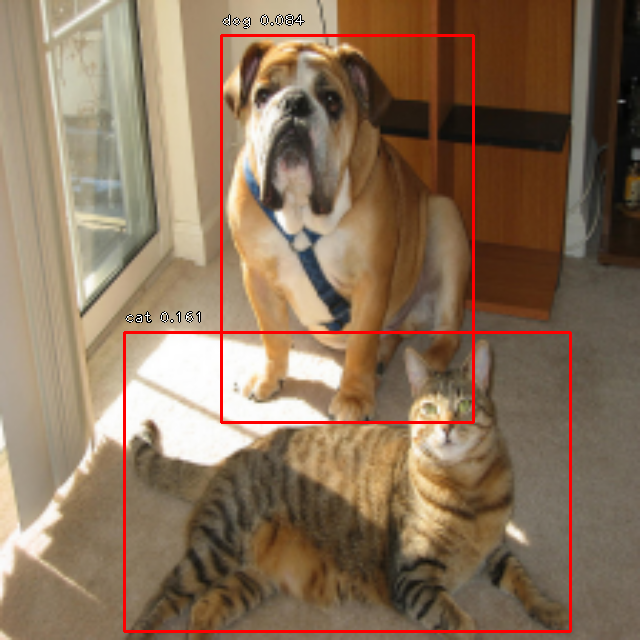

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

img, labels_lst, bbox_lst, retinanet, tensor_test = detect_image("./data/test", "./retinanet_pretrained.pt", "./class_mapping.csv")
Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [9]:
image_float_np = img / 255
image_float_np.shape


(640, 640, 3)

## EigenGRADCAM

- In the following cell, I used EigenCAM, which return the first principle component of the activations, which will correspond with the dominant object (most of the time). 

- However, in case there are multiple objects (of the same class), EigenCAM will fail miserably and emphasize the oposite of what we expect (i.e it will highlight the background instead of the object). 

- This phenomenon can be observed by using "./data/Puppies_(4984818141).jpg" instead of the cat & dog picture.


In [10]:
# NOTE: This cell contains neccessary class and functions to customize
# CAM visualization for Retinanet
def pass_to_this_layer(layer, x):       #Compute features map from FPN's features
    out = layer.conv1(x)
    out = layer.act1(out)
    out = layer.conv2(out)
    out = layer.act2(out)
    out = layer.conv3(out)
    out = layer.act3(out)
    out = layer.conv4(out)
    out = layer.act4(out)

    return out

def retinanet_reshape_transform(x): #Compute activations
    acts = [pass_to_this_layer(retinanet.classificationModel, feat) for feat in x]
    activations = []
    target_size = acts[0].size()[-2 : ]
    for value in acts:
        activations.append(torch.nn.functional.interpolate(value, target_size, mode='bilinear'))
    activations = torch.cat(activations, axis=1)
    return activations


import torchvision
class RetinanetBBoxScoreTarget: #Define target class for EigenCAM
    """ For every original detected bounding box specified in "bounding boxes",
        assign a score on how the current bounding boxes match it,
            1. In IOU
            2. In the classification score.
        If there is not a large enough overlap, or the category changed,
        assign a score of 0.

        The total score is the sum of all the box scores.
    """

    def __init__(self, labels, bounding_boxes, iou_threshold=0.5):
        self.labels = labels
        self.bounding_boxes = bounding_boxes
        self.iou_threshold = iou_threshold

    def __call__(self, model_outputs):
        output = torch.Tensor([0])
        if torch.cuda.is_available():
            output = output.cuda()

        if len(model_outputs[2]) == 0:
            return output

        for box, label in zip(self.bounding_boxes, self.labels):
            box = torch.Tensor(box[None, :])
            if torch.cuda.is_available():
                box = box.cuda()

            ious = torchvision.ops.box_iou(box, model_outputs[2])
            index = ious.argmax()
            if ious[0, index] > self.iou_threshold and model_outputs[1][index] == label:
                score = ious[0, index] + model_outputs[0][index]
                output = output + score
        return output


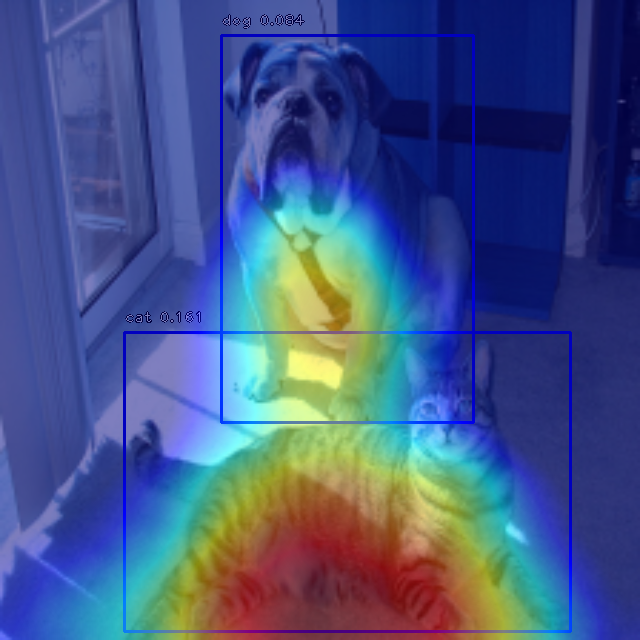

In [11]:
target_layers = [retinanet.fpn] #Due to problem (2) defined at the start, I have to define the FPN as "target layers"
retinanet.eval()
targets = [RetinanetBBoxScoreTarget(labels=labels_lst, bounding_boxes=bbox_lst)]
cam = EigenCAM(retinanet, 
               target_layers, 
               use_cuda=True, 
               reshape_transform=retinanet_reshape_transform,
               )
grayscale_cam = cam(tensor_test, targets=targets)
grayscale_cam = grayscale_cam[0, :]
cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb=True)
del grayscale_cam
Image.fromarray(cam_image)

## Ablatation GradCAM
The following cells are my attempt at visualizing Ablation GradCAM. On theory, this would give better class descrimination, meaning it would highlight only the parts that correspond with a specific category, and not those of other categories. This means it will fix the problem of EigenCAM


However, I failed to visualize the Ablation GradCAM here.

In [ ]:
# from pytorch_grad_cam.ablation_layer import AblationLayer

# class AblationLayerRetinanet(AblationLayer):
#     def __init__(self):
#         super(AblationLayerRetinanet, self).__init__()
        
#     def set_next_batch(self, input_batch_index, activations, num_channels_to_ablate):
#         self.activations = []
#         for index, value in enumerate(activations):
#             fpn_activation = value[input_batch_index, :, :, :].clone().unsqueeze(0)
#             self.activations[index] = fpn_activation.repeat(num_channels_to_ablate, 1, 1, 1)
            
#         def __call__(self, x):
#             result = self.activations
#             layers = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4}
#             num_channels_to_ablate = result[4].size(0)
#             for i in range(num_channels_to_ablate):
#                 pyramid_layer = int(self.indices[i] / 256)
#                 index_in_pyramid_layer = int(self.indicies[i] % 256)
#                 result[layers[pyramid_layer]][i, index_in_pyramid_layer, :, :] = -1000
#             return result

In [ ]:
# COLORS = np.random.uniform(0, 255, size=(len(class_lst), 3))

# def draw_boxes(boxes, labels, classes, image):
#     for i, box in enumerate(boxes):
#         color = COLORS[labels[i]]
#         cv2.rectangle(
#             image,
#             (int(box[0]), int(box[1])),
#             (int(box[2]), int(box[3])),
#             color, 2
#         )
#         cv2.putText(image, classes[i], (int(box[0]), int(box[1] - 5)),
#                     cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
#                     lineType=cv2.LINE_AA)
#     return image

# def renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam):
#     """Normalize the CAM to be in the range [0, 1] 
#     inside every bounding boxes, and zero outside of the bounding boxes. """
#     renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
#     images = []
#     for x1, y1, x2, y2 in boxes:
#         img = renormalized_cam * 0
#         img[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
#         images.append(img)
    
#     renormalized_cam = np.max(np.float32(images), axis = 0)
#     renormalized_cam = scale_cam_image(renormalized_cam)
#     eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
#     image_with_bounding_boxes = draw_boxes(boxes, labels_lst, classes, eigencam_image_renormalized)
#     return image_with_bounding_boxes

In [ ]:
# from pytorch_grad_cam import AblationCAM
# cam = AblationCAM(retinanet,
#                target_layers, 
#                use_cuda=torch.cuda.is_available(), 
#                reshape_transform=retinanet_reshape_transform,
#                ablation_layer=AblationLayerRetinanet())

# grayscale_cam = cam(tensor_test, targets=targets)[0, :]
# Image.fromarray(renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam))